## Ensemble correlation
* Reads in data from CESM2 historical ensemble
* Calculates annual fluxes
* Generates anomalies by subtracting ensemble year from ensemble mean year
* Plots correlation between C flux and climimate anomalies

borrows from Katie's script at https://github.com/NCAR/ctsm_python_gallery/blob/master/notebooks/ReadingEnsembleData.ipynb

In [1]:
import xarray as xr
import esmlab
from ctsm_py import utils
import intake
import numpy as np

# some resources for plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Try reading in with dictionary and intake
Not able to get to work, example using intake would be helpful here

In [2]:
'''
#intake.open_esm_metadatastore
# try using intake-esm dictionary for file IO
catalog = intake.open_esm_metadatastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/campaign-cesm2-cmip6-timeseries.json")
#catalog = intake.open_catalog('/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json')
catalog
'''

'\n#intake.open_esm_metadatastore\n# try using intake-esm dictionary for file IO\ncatalog = intake.open_esm_metadatastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/campaign-cesm2-cmip6-timeseries.json")\n#catalog = intake.open_catalog(\'/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json\')\ncatalog\n'

### Read in data manually

In [3]:
# set number of ensembles 
niter = 11

# Set output path and ensemble name
# In this case, all ensemble members are named "hydro_ensemble_LHC_X" where X is the member number
path = '/gpfs/fs1/collections/cdg/timeseries-cmip6/'
case = 'b.e21.BHIST.f09_g17.CMIP6-historical.'

# Set output variables of interest
var = ['GPP','TBOT','TWS']

In [4]:
# Create a list of paths to each ensemble member output directory
# Here is where we use unix wildcards (e.g., *) to get all the files in each directory
# use zfill to get ensemble numbers!

full_paths0 = [path+case+str(i+1).zfill(3)+'/lnd/proc/tseries/month_1/*clm2.h0.'+var[0]+'*' for i in range(niter)] # all history files in the folder
full_paths1 = [path+case+str(i+1).zfill(3)+'/lnd/proc/tseries/month_1/*clm2.h0.'+var[1]+'*' for i in range(niter)] # all history files in the folder
full_paths2 = [path+case+str(i+1).zfill(3)+'/lnd/proc/tseries/month_1/*clm2.h0.'+var[2]+'*' for i in range(niter)] # all history files in the folder

full_paths2[:5] # look at the first 10 paths

['/gpfs/fs1/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.001/lnd/proc/tseries/month_1/*clm2.h0.TWS*',
 '/gpfs/fs1/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.002/lnd/proc/tseries/month_1/*clm2.h0.TWS*',
 '/gpfs/fs1/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.003/lnd/proc/tseries/month_1/*clm2.h0.TWS*',
 '/gpfs/fs1/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.004/lnd/proc/tseries/month_1/*clm2.h0.TWS*',
 '/gpfs/fs1/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.005/lnd/proc/tseries/month_1/*clm2.h0.TWS*']

In [5]:
# Create a preprocess function that returns a specific variable or variables
# This also doesn't seem necessary since data are already single variable time series
def preprocess(ds):
    return ds[var[0]]

CPU times: user 132 ms, sys: 28 ms, total: 160 ms
Wall time: 159 ms


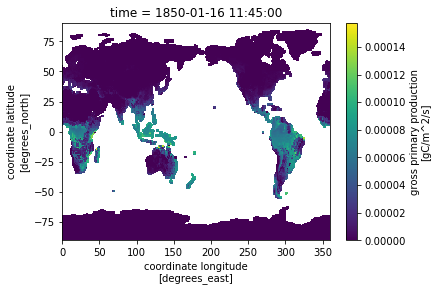

In [6]:
%%time
# Test opening the first ensemble member
da_model = utils.time_set_mid(xr.open_mfdataset(full_paths0[0], decode_times=True, combine='by_coords'), 'time')
da_model.GPP.isel(time=0).plot();

### Open each ensemble member as a list of datasets
This takes some time...

In [7]:
%%time
da_model0 = [utils.time_set_mid(xr.open_mfdataset(p, decode_times=True, combine='by_coords'), 'time') for p in full_paths0]
da_model1 = [utils.time_set_mid(xr.open_mfdataset(p, decode_times=True, combine='by_coords'), 'time') for p in full_paths1]
da_model2 = [utils.time_set_mid(xr.open_mfdataset(p, decode_times=True, combine='by_coords'), 'time') for p in full_paths2]

CPU times: user 3min 12s, sys: 1min 4s, total: 4min 16s
Wall time: 3min 56s


### Create an ensemble member dimension to index on
#### Concatenate the ensemble members along new ensemble dimension


In [8]:
ensdim = xr.DataArray(list(range(1,(niter+1))), dims='ens', name='ens') # or can use np.arange
ensdim
da_model_concat0 = xr.concat(da_model0, dim=ensdim)
da_model_concat1 = xr.concat(da_model1, dim=ensdim)
da_model_concat2 = xr.concat(da_model2, dim=ensdim)
da_model_concat0.GPP

<xarray.DataArray 'GPP' (ens: 11, time: 1980, lat: 192, lon: 288)>
dask.array<concatenate, shape=(11, 1980, 192, 288), dtype=float32, chunksize=(1, 600, 192, 288)>
Coordinates:
  * time     (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

### Combine vars into one dataset, indexed by ens * time * lat * lon
#### Subset into dataset to just get variables you want

In [9]:
da_model_concat0[var[1]] = da_model_concat1[var[1]]
da_model_concat0[var[2]] = da_model_concat2[var[2]]
ds = da_model_concat0[var]

#### Quick plot to see if ensemble are actually different

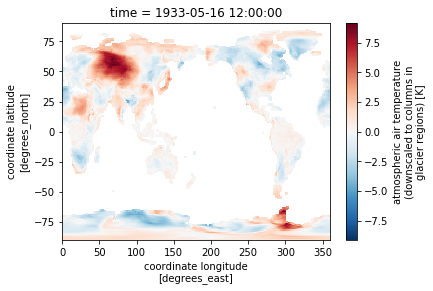

In [10]:
temp = ds.TBOT.isel(time=1000)
temp2 = temp.isel(ens=0) - temp.isel(ens=1)
temp2.plot();

### Calculate annual means

In [11]:
s2y = 3600 * 24 * 365
ds_ann_temp = utils.weighted_annual_mean(ds[var[0]])
ds_ann = xr.Dataset( coords={'time': ds_ann_temp.time , "lat": ds.lat, "lon": ds.lon} )

for i in range(len(var)):
    ds_ann[var[i]] = utils.weighted_annual_mean(ds[var[i]])
    if (i == 0):
        ds_ann[var[i]] = ds_ann[var[i]] * s2y
    ds_ann[var[i]].attrs = ds[var[i]].attrs
    if (i == 0 ):
        ds_ann[var[i]].attrs['units'] = 'gC $\mathregular{m^{-2}}$ $\mathregular{y^{-1}}$ '

print(ds_ann)    

<xarray.Dataset>
Dimensions:  (ens: 11, lat: 192, lon: 288, time: 165)
Coordinates:
  * time     (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    GPP      (ens, time, lat, lon) float64 dask.array<chunksize=(1, 50, 192, 288), meta=np.ndarray>
    TBOT     (ens, time, lat, lon) float64 dask.array<chunksize=(1, 50, 192, 288), meta=np.ndarray>
    TWS      (ens, time, lat, lon) float64 dask.array<chunksize=(1, 50, 192, 288), meta=np.ndarray>


### Quick look to see if global sums seem OK
These are not weighted by grid area!

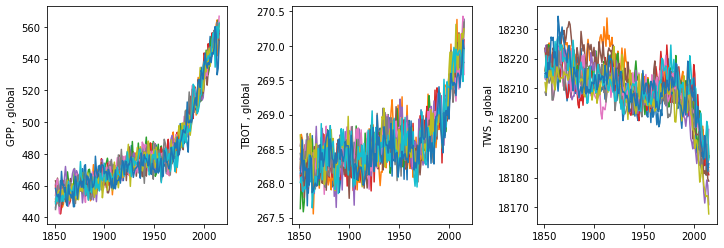

In [12]:
plt.figure(figsize=[12,4])
for i in range(len(var)):
    plt.subplot(1, 3, (1+i))
    plt.ylabel(var[i] + ' , global')
    for j in range(niter):
        plt.plot(ds_ann.time, ds_ann[var[i]].isel(ens=j).mean(dim=('lat','lon')))
plt.subplots_adjust(wspace=0.36);

### Subtract annual values for each ensemble from ensemble mean

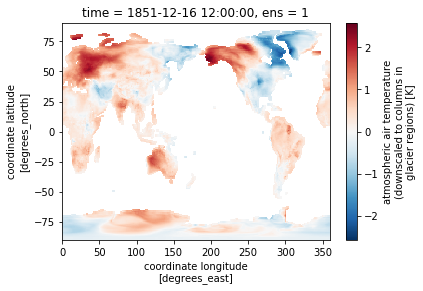

In [13]:
ds_ann_mean = ds_ann.mean(dim='ens') 
ds_ann_anom = ds_ann - ds_ann_mean
ds_ann_anom.TBOT.isel(ens=0,  time=1).plot();

In [14]:
#  mask out non-land points & last n years of simulation
nyears = 55
ds_ann_anom = ds_ann_anom.where(ds_ann.GPP>0)
ds_ann_anom = ds_ann_anom.isel(time=slice(-nyears,None))
print(ds_ann_anom)

<xarray.Dataset>
Dimensions:  (ens: 11, lat: 192, lon: 288, time: 55)
Coordinates:
  * time     (time) object 1960-12-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    GPP      (ens, time, lat, lon) float64 dask.array<chunksize=(1, 40, 192, 288), meta=np.ndarray>
    TBOT     (ens, time, lat, lon) float64 dask.array<chunksize=(1, 40, 192, 288), meta=np.ndarray>
    TWS      (ens, time, lat, lon) float64 dask.array<chunksize=(1, 40, 192, 288), meta=np.ndarray>


#### Plot to make sure anomalies seem OK
Again, these are just global grid cell mean values  for each ensemble,

! Not weighted for grid areas & land frac !

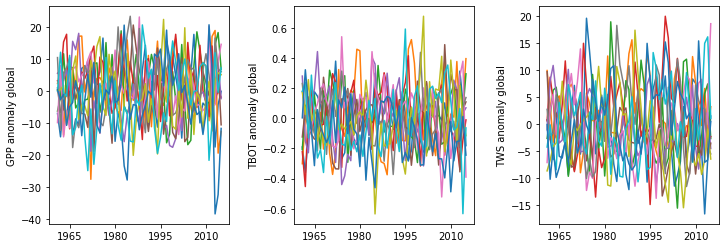

In [15]:
plt.figure(figsize=[12,4])
for i in range(len(var)):
    plt.subplot(1, 3, (1+i))
    plt.ylabel(var[i] + ' anomaly global')
    for j in range(niter):
        plt.plot(ds_ann_anom.time, ds_ann_anom[var[i]].isel(ens=j).mean(dim=('lat','lon')))
plt.subplots_adjust(wspace=0.36);

#### Flatten along _ens_ & _time_ dimensions with stack

In [16]:
ds_stack = ds_ann_anom.stack(dim_0=('ens', 'time'))
ds_stack = ds_stack.reset_index('dim_0').drop(['ens', 'time'])
print(ds_stack)
ds_ann_anom

<xarray.Dataset>
Dimensions:  (dim_0: 605, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
Dimensions without coordinates: dim_0
Data variables:
    GPP      (lat, lon, dim_0) float64 dask.array<chunksize=(192, 288, 55), meta=np.ndarray>
    TBOT     (lat, lon, dim_0) float64 dask.array<chunksize=(192, 288, 55), meta=np.ndarray>
    TWS      (lat, lon, dim_0) float64 dask.array<chunksize=(192, 288, 55), meta=np.ndarray>


<xarray.Dataset>
Dimensions:  (ens: 11, lat: 192, lon: 288, time: 55)
Coordinates:
  * time     (time) object 1960-12-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    GPP      (ens, time, lat, lon) float64 dask.array<chunksize=(1, 40, 192, 288), meta=np.ndarray>
    TBOT     (ens, time, lat, lon) float64 dask.array<chunksize=(1, 40, 192, 288), meta=np.ndarray>
    TWS      (ens, time, lat, lon) float64 dask.array<chunksize=(1, 40, 192, 288), meta=np.ndarray>


## Calculate correlations between annual GPP and climate anomalies


In [17]:
import corrFunc as cor
GPP_TBOT = cor.pearson_correlation(ds_stack.GPP.chunk({'dim_0': -1}), ds_stack.TBOT.chunk({'dim_0': -1}), 'dim_0')
GPP_TWS = cor.pearson_correlation(ds_stack.GPP.chunk({'dim_0': -1}), ds_stack.TWS.chunk({'dim_0': -1}), 'dim_0')
TBOT_TWS = cor.pearson_correlation(ds_stack.TBOT.chunk({'dim_0': -1}), ds_stack.TWS.chunk({'dim_0': -1}), 'dim_0')

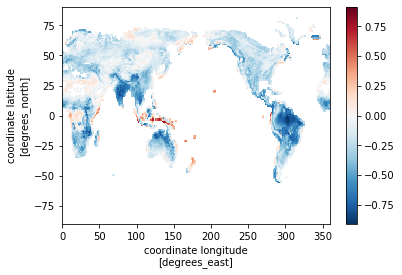

## Create function for nice maps

In [21]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ## Global
    # ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ## North America
    ax.set_extent([-170,-50,18,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.92), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)
        #fig.colorbar(im, ax=ax,shrink=0.3, pad=0, fraction = 0.03)

In [ ]:
# Now call the map_function
# projection here determines shape of map

panel = ['(a)','(b)','(c)']# to label each panel on plot...  ,'(d)','(e)','(f)','(g)']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

# plot only NA, latitudes 20 to 80 and longitudes -170 to -50.
# don't need to slice here, as it's done with function, above
a = 20
b = 80
c = 360-170
d = 360-50

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    if (i == 0):
        #.sel(lat=slice(a,b), lon=slice(c,d))
        map_function(GPP_TBOT, panel=panel[i], 
                     ax=ax, title='Annual GPP ~ TBOT', vmax=1, vmin=-1, cmap='BrBG',cb=0)

    if (i == 1):
        map_function(GPP_TWS, panel=panel[i], 
                     ax=ax, title='Annual GPP ~ TWS', vmax=1, vmin=-1, cmap='BrBG',cb=0)

    if (i == 2):
        map_function(TBOT_TWS, panel=panel[i], 
                     ax=ax, title='Annual TBOT ~ TWS', vmax=1, vmin=-1, cmap='BrBG',cb=1)
        
plt.savefig('/glade/scratch/wwieder/CESM2_hist_C-clim_corrNA.eps')

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
